In this assignment we will look at a typical image based machine learning task.

`@author: Thomas Duffy`

## Image classification 

For this task the whole image is used to classify what's happening.

For this specific task, we will be trying to classify COVID-19 using pneumonia x-rays.  Please note, the literature has mostly suggested CT scans are not an effective way of figuring out what type of disease you have.  This exercise is for academic purposes _only_.

Steps:


1. Download the pneumonia data.  

    You can find it [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Move the folder to this directory and unzip it.  Please don't change any folder names or the below script will not work.  Also make sure the folder is in the same directory as this notebook!

2. load the pneumonia data into a dataframe:

In [1]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import skimage.transform
import skimage.color

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.keras.__version__

'2.2.4-tf'

In [4]:
def load_training_data():
    paths = [
        "chest_xray/train/NORMAL/*",
        "chest_xray/train/PNEUMONIA/*"
    ]
    labels = []
    image_paths = []
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/train/NORMAL/*":
                labels.append("NORMAL")
            if path == "chest_xray/train/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            image_paths.append(im_path)
    return image_paths, labels

def load_testing_data():
    paths = [
        "chest_xray/test/NORMAL/*",
        "chest_xray/test/PNEUMONIA/*"
    ]
    labels = []
    image_paths = []
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/test/NORMAL/*":
                labels.append("NORMAL")
            if path == "chest_xray/test/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            image_paths.append(im_path)
    return image_paths, labels

In [5]:
train_paths, train_labels = load_training_data()
test_paths, test_labels = load_testing_data()

3. read the data into memory, I recommend open-cv for this:

`python -m pip install opencv-python` 

if you don't already have it!

4. resize the images to a standard size - 

Note: it ought to be a box.  So the width and height should be the same size.

In [6]:
def get_image_features(image_paths, shape):
    height, width, channels = shape
    array = np.zeros((len(image_paths), height, width, channels))
    for i, path in enumerate(image_paths):
        im = Image.open(path)
        as_array = np.asarray(im)
        if len(as_array.shape) == 2: # convert to 3 channels (required input to VGG)
            as_array = skimage.color.gray2rgb(as_array)
        resized = skimage.transform.resize(as_array, shape)
        array[i,:,:] = resized
        if (i + 1) % 500 == 0:
            print(f'Finished loading {i+1} samples')
    return array

Next you'll need to do the same for the labels:

Note: You'll need to apply the `to_categorical` function after transforming to a numpy array

In [7]:
categorical_mapping = { label: i for i, label in enumerate(set(train_labels)) }
categorical_mapping

{'NORMAL': 0, 'PNEUMONIA': 1}

In [8]:
def labels_to_np_array(labels, mapping):
    return np.array([mapping[label] for label in labels])

7. Seperate into train and test with `train_test_split` from scikit-learn

In [9]:
# how many training samples should we get?
len(train_paths)

5216

In [10]:
IMAGE_SHAPE = (128, 128, 3)

In [11]:
full_training_X = get_image_features(train_paths, IMAGE_SHAPE)
full_training_y = labels_to_np_array(train_labels, categorical_mapping)

Finished loading 500 samples
Finished loading 1000 samples
Finished loading 1500 samples
Finished loading 2000 samples
Finished loading 2500 samples
Finished loading 3000 samples
Finished loading 3500 samples
Finished loading 4000 samples
Finished loading 4500 samples
Finished loading 5000 samples


In [12]:
full_training_X.shape

(5216, 128, 128, 3)

In [13]:
full_training_X.shape[0] == full_training_y.shape[0]

True

In [14]:
SEED = 42

In [15]:
from sklearn.model_selection import train_test_split

TEST_SET_SIZE = .2

X_train, X_test, y_train, y_test = train_test_split(
    full_training_X, full_training_y, test_size=TEST_SET_SIZE, random_state=SEED
)

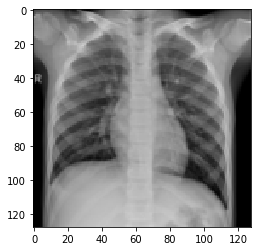

In [16]:
# sanity check, what does one image look like?
_ = plt.imshow(X_train[2])

In [ ]:
# what's the class proportion?


8. Make the last four layers of VGG16 with imagenet weights trainable and then retrain the model.

To understand how to do this, please see the following tutorial:

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [25]:
tf.keras.backend.clear_session()

In [26]:
vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)

In [27]:
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
for layer in vgg_conv.layers:
    print(f'Is {layer.__class__.__name__} traininable? {layer.trainable}')

Is InputLayer traininable? False
Is Conv2D traininable? False
Is Conv2D traininable? False
Is MaxPooling2D traininable? False
Is Conv2D traininable? False
Is Conv2D traininable? False
Is MaxPooling2D traininable? False
Is Conv2D traininable? False
Is Conv2D traininable? False
Is Conv2D traininable? False
Is MaxPooling2D traininable? False
Is Conv2D traininable? False
Is Conv2D traininable? False
Is Conv2D traininable? False
Is MaxPooling2D traininable? False
Is Conv2D traininable? True
Is Conv2D traininable? True
Is Conv2D traininable? True
Is MaxPooling2D traininable? True


In [28]:
model = tf.keras.models.Sequential()

model.add(vgg_conv)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 23,106,370
Trainable params: 15,471,106
Non-trainable params: 7,635,264
_________________________________________________________________


In [30]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
EPOCHS, BATCH_SIZE = 5, 32

In [32]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 3337 samples, validate on 835 samples
Epoch 1/5
3337/3337 [==============================] - 251s 75ms/sample - loss: 0.4149 - accuracy: 0.8421 - val_loss: 0.1064 - val_accuracy: 0.9617
Epoch 2/5
3337/3337 [==============================] - 263s 79ms/sample - loss: 0.1003 - accuracy: 0.9670 - val_loss: 0.0676 - val_accuracy: 0.9737
Epoch 3/5
3337/3337 [==============================] - 257s 77ms/sample - loss: 0.0539 - accuracy: 0.9808 - val_loss: 0.2894 - val_accuracy: 0.8970
Epoch 4/5
3337/3337 [==============================] - 256s 77ms/sample - loss: 0.0429 - accuracy: 0.9838 - val_loss: 0.1013 - val_accuracy: 0.9701
Epoch 5/5
3337/3337 [==============================] - 257s 77ms/sample - loss: 0.0280 - accuracy: 0.9892 - val_loss: 0.0870 - val_accuracy: 0.9749


8. Check your score with classification_report from scikit-learn

Now that you've trained your model, call `model.predict` to get the predicted values for classification.  
Then compare your predicted values with y_test

In [33]:
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       287
           1       0.98      0.99      0.98       757

    accuracy                           0.98      1044
   macro avg       0.98      0.96      0.97      1044
weighted avg       0.98      0.98      0.98      1044



9. Data augmentation

Now that you have a classifier, let's see if data augmentation improves things!  

You can use the `ImageDataGenerator` that comes with keras.  Here's how to import it:

`from tensorflow.keras.preprocessing.image import ImageDataGenerator`

Here's the documentation: https://keras.io/preprocessing/image/

Here's an example of it getting used in the wild, in case you get stuck:

https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

In [35]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_gen.fit(X_train)

10. retrain your classifier

Now that you have augmented training data, please retrain your classifier.  The code should basically be the same.

In [36]:
augmented_model = tf.keras.models.Sequential()

augmented_model.add(vgg_conv)

augmented_model.add(tf.keras.layers.Flatten())
augmented_model.add(tf.keras.layers.Dense(1024, activation='relu'))
augmented_model.add(tf.keras.layers.Dropout(0.5))
augmented_model.add(tf.keras.layers.Dense(2, activation='softmax'))

augmented_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 23,106,370
Trainable params: 15,471,106
Non-trainable params: 7,635,264
_________________________________________________________________


In [37]:
augmented_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
augmented_model.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - 0.2)) // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * 0.2) // BATCH_SIZE
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 104.0 steps, validate for 26.0 steps
Epoch 1/5
104/104 [==============================] - 290s 3s/step - loss: 1167037966.7979 - accuracy: 0.5018 - val_loss: 246794318.7692 - val_accuracy: 0.0000e+00
Epoch 2/5
104/104 [==============================] - 302s 3s/step - loss: 26628495420.0364 - accuracy: 0.5064 - val_loss: 24828910985.8462 - val_accuracy: 1.0000
Epoch 3/5
104/104 [==============================] - 302s 3s/step - loss: 130734932957.9404 - accuracy: 0.5079 - val_loss: 37757608566.1538 - val_accuracy: 0.0000e+00
Epoch 4/5
104/104 [==============================] - 314s 3s/step - loss: 238956677773.3564 - accuracy: 0.4921 - val_loss: 359790946146.4615 - val_accuracy: 1.0000
Epoch 5/5
104/104 [==============================] - 311s 3s/step - loss: 376518199594.6128 - accuracy: 0.5057 - val_loss: 163924531357.5385 - val_accuracy: 0.0000e+00


11. re-evaluate your classifier

Now that you've augmented the data, please re-evaluate your classifer.  Use classification report like before.

In [43]:
from sklearn.metrics import classification_report

y_pred = augmented_model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       287
           1       0.73      1.00      0.84       757

    accuracy                           0.73      1044
   macro avg       0.36      0.50      0.42      1044
weighted avg       0.53      0.73      0.61      1044



/home/thomas/miniconda3/envs/deep-learning-spring-20/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12. Evaluate the difference with data augmentation and without:

Did things improve?  Did they stay the same?  Did they get worse?  Please try to come up with an explanation of why you got the results you did.

### Explanation of results go here

13. Getting COVID19 data

Now that you have a trained classifier with pneumonia, we are going to use this with COVID data.  

Clone this repo:

https://github.com/ieee8023/covid-chestxray-dataset

use the clone command: `git clone [REPO]`

to get the data locally.  

Make sure to run this command in the same folder as this jupyter notebook.

14. Read the data into memory

The set up for this data repository is a little different.  Please use the following code to read the data into memory:

In [5]:
import pandas as pd

def get_covid19():
    base = "covid-chestxray-dataset/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    image_paths = []
    for index, row in metadata.iterrows():
        labels.append(row["finding"])
        image_paths.append(base+row["filename"])
    return labels, image_paths

labels, covid_image_paths = get_covid19()

15. preprocess images

you'll need to run the following functions on this data:

1. load_images
2. resize_images
3. greyscale_images
4. features_to_np_array
5. labels_to_np_array

Make sure to run each of those functions in order!

In [8]:
# add your function calls to covid_image_paths here

16. Strip out labels other than 'No Finding' and 'COVID-19' from the dataset

There are two straight forward ways to do this:

1) use a for-loop and keep track of indices

2) read labels and features into a dataframe and then filter to those two label types.  Your choice!

In [9]:
# label reduction code goes here

17. Predict on the new images

Here you'll use the classifier you trained on just pneumonia/not pneumonia to try and classify COVID-19 and no finding.  You'll use the pneumonia/not pneumonia classifier as a featurizer to do this.

Much of the code has been written, you'll just need to supply your trained classifier as input.

Please predict the labels from the classifier.  Then run `classification_report` to see how well your classifier did.

In [ ]:
#prediction code goes here

import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import glob
import code

def extract_features_covid(model, width, height):
    base = "covid-chestxray-dataset/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    image_paths = []
    for index, row in metadata.iterrows():
        if row["finding"] == "COVID-19":
            labels.append("COVID")
            image_paths.append(base+row["filename"])
            im = cv2.imread(im_path)
            im = cv2.resize(im, (width, height))
            features = model.predict(img)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

def extract_features_not_covid(model, width, height):
    feature_list = []
    labels = []
    paths = [
        "chest_xray/test/NORMAL/*",
        "chest_xray/test/PNEUMONIA/*",
        "chest_xray/train/NORMAL/*",
        "chest_xray/train/PNEUMONIA/*"
        
    ]
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/train/NORMAL/*":
                labels.append("CLEAR TRAIN")
            if path == "chest_xray/test/NORMAL/*":
                labels.append("CLEAR TEST")
            if path == "chest_xray/train/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            im = cv2.imread(im_path)
            im = cv2.resize(im, (width, height))
            features = model.predict(img)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

# please make a copy of your tuned model and save it to variable:
# untuned_model = [YOUR MODEL NAME GOES HERE]

# please specify the width and height you used for the image preprocessing
# width = [YOUR WIDTH GOES HERE]
# height = [YOUR HEIGHT GOES HERE]

covid_features, covid_labels = extract_features_covid(untuned_model, width, height)
non_covid_features, non_covid_labels = extract_features_not_covid(untuned_model, width, height)
features = covid_features + non_covid_features
labels = covid_labels + non_covid_labels
X_train = []
y_train = []
X_test = []
y_test = []
for index, label in enumerate(labels):
    if label == "CLEAR TRAIN":
        X_train.append(features[index])
        y_train.append(0)
    if label == "PNEUMONIA":
        X_train.append(features[index])
        y_train.append(1)
    if label == "COVID":
        X_test.append(features[index])
        y_test.append(1)
    if label == "CLEAR TEST":
        X_test.append(features[index])
        y_test.append(0)

logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
print(classification_report(y_test, y_pred))

18. Compare and contrast how the classifier did on Pneumonia versus COVID-19

Did it do as well?  Worse?  About the same?  What conclusions can you draw?

### Add your answers here!

Now that we've looked at a bunch of base cases, let's see if we can improve things by changing the model architecture.  We'll do this with a bunch of discrete steps

1. Change the number of trainable layers

Here you will make more of the layers trainable.  For this we are going to use cross validation to try and figure out which the optimal number of trainable layers.  Please us from the last 6 layers to one layer.  So your range should be:

```
trainable_range = [-6, -5, -4, -3, -2, -1]
```

Also, your X and y data should be the pneumonia data only.  Since that's what we trained on.  We should not assume we have access to the COVID data, except for testing, which will do later on.

Here's a blog post detailing how to set this up: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Note you'll need to set the number of trainable layers inside of `model_create` in order to make this tunable.  

Please report mean and standard deviation for accuracy.

In [12]:
# Cross validation code goes here

2. Analyze your results

Do you think that changing the number of tunable layers matters?  Does it improve classification accuracy enough to warrant changing the number of tunable layers?  

### Analysis and explanation go here

2. Tune over a layer activation function

Please set the number of tunable layers to 4 again.

Now we are going to make the layer activation tunable.  

To do this, please change the model_create function so that each layer has it's own tunable activation function.  Then run your new cross validation code.

In [13]:
# cross validation code goes here

3. Analyze your results

Does your choice of activation function matter?  When does the activation function perform best?  

Things to consider:

* Specifically does choosing the same activation function for all of the layers do best? 
* Does choosing different activation functions for each of the layers do best?
* Are they all within the same approximate accuracy range?
* do things vary wildly?

### Analysis and explanation go here

4. Tune over more hyperparameters

Now that we've tuned the activation functions, let's try tuning more parameters.  This time add tuning for the following parameters:

* number of neurons per layer
* weight initialization
* optimizer
* weight constraint
* activation function
* learning rate

Here is a great post on the range of values you should consider: https://www.wandb.com/articles/fundamentals-of-neural-networks

Here is some code that is also useful: https://www.kaggle.com/lavanyashukla01/training-a-neural-network-start-here

for understanding this practically.

In [14]:
# cross validation code goes here

5. Tune over data augmentation

Here you'll take the best hyperparameters from your neural network, with 4 trainable layers, and then add them to a pipeline.  We will then tune over data augmentation parameters.  Report out your mean and standard deviation of accuracy.

Here we will create a scikit-learn pipline:

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

If you need an example with gridsearch and pipeline:

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

As a reminder, here is the documentation for data augmentation:

https://keras.io/preprocessing/image/

In [ ]:
#cross validation code goes here

6. Analyze your results

Now that you've tuned over model parameters and preprocessing, what has a bigger impact?  Why do you think that might be the case?

### Analysis and explanation goes here

7. Using your best model and preprocessing to train a new model

Now you should select the best hyperparameters for the neural network and the best hyperparameters for the preprocesser and then combine them into a scikit-learn pipeline.  Next train a classifier with these new tuned hyperparameters.

In [15]:
#classifer generation code goes here

8. Let's see if things improved - time for `classification_report`

Now that you've tuned your model, let's see how well it does on our test set!  First call predict on the test data to get a prediction.  Then use `classification_report` to see how well the model does.

In [16]:
# prediction code goes here

9. Analsis and comparison

Now that you've seen how well your classifier does when it's been tuned, compare this with your previous model, that was untuned.  Are the precision, recall and f1-scores substantially different?  Why or why not?

### Analysis and explanation goes here

10. Prediction on COVID binary classification task with tuned model

Now you'll use your tuned classifier to try and predict on the binary COVID19 case.  Please change the model to your tuned model!

In [ ]:
#prediction code goes here

import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import glob
import code

def extract_features_covid(model, width, height):
    base = "covid-chestxray-dataset/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    image_paths = []
    for index, row in metadata.iterrows():
        if row["finding"] == "COVID-19":
            labels.append("COVID")
            image_paths.append(base+row["filename"])
            im = cv2.imread(im_path)
            im = cv2.resize(im, (width, height))
            features = model.predict(img)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

def extract_features_not_covid(model, width, height):
    feature_list = []
    labels = []
    paths = [
        "chest_xray/test/NORMAL/*",
        "chest_xray/test/PNEUMONIA/*",
        "chest_xray/train/NORMAL/*",
        "chest_xray/train/PNEUMONIA/*"
        
    ]
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/train/NORMAL/*":
                labels.append("CLEAR TRAIN")
            if path == "chest_xray/test/NORMAL/*":
                labels.append("CLEAR TEST")
            if path == "chest_xray/train/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            im = cv2.imread(im_path)
            im = cv2.resize(im, (width, height))
            features = model.predict(img)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

# please make a copy of your tuned model and save it to variable:
# tuned_model = [YOUR MODEL NAME GOES HERE]

# please specify the width and height you used for the image preprocessing
# width = [YOUR WIDTH GOES HERE]
# height = [YOUR HEIGHT GOES HERE]

covid_features, covid_labels = extract_features_covid(tuned_model, width, height)
non_covid_features, non_covid_labels = extract_features_not_covid(tuned_model, width, height)
features = covid_features + non_covid_features
labels = covid_labels + non_covid_labels
X_train = []
y_train = []
X_test = []
y_test = []
for index, label in enumerate(labels):
    if label == "CLEAR TRAIN":
        X_train.append(features[index])
        y_train.append(0)
    if label == "PNEUMONIA":
        X_train.append(features[index])
        y_train.append(1)
    if label == "COVID":
        X_test.append(features[index])
        y_test.append(1)
    if label == "CLEAR TEST":
        X_test.append(features[index])
        y_test.append(0)

logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
print(classification_report(y_test, y_pred))

11. Analyze your results

Now that you've seen the results of your tuned model, compare those with the results of the untuned model.  Did things get better? Worse?  Why do you think this may or may not be the case?

### Analysis of your results goes here